# 📊 Stock Sentiment Analysis - Versión Mejorada

Análisis avanzado del sentimiento de noticias sobre **Take-Two Interactive** y su correlación con el precio de las acciones.

## 🚀 Mejoras Implementadas:
1. ✅ **Análisis de correlación estadística**
2. ✅ **Predicción básica con Machine Learning**
4. ✅ **Análisis de múltiples fuentes**
6. ✅ **Detección de eventos específicos (GTA 6)**
8. ✅ **Mejoras técnicas** (manejo de errores, logging, funciones modulares)

In [1]:
# ============================================================================
# CELDA 1: INSTALACIÓN DE DEPENDENCIAS
# ============================================================================
# Instalar todas las librerías necesarias

%pip install numpy \
             pandas \
             yfinance \
             nltk \
             vaderSentiment \
             requests \
             scikit-learn \
             matplotlib \
             seaborn \
             --quiet \
             --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: C:\Users\gonza\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
# ============================================================================
# CELDA 2: IMPORTS Y CONFIGURACIÓN
# ============================================================================
# Importar todas las librerías necesarias para el análisis

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuración de visualización
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Descargar recursos de NLTK (necesarios para procesamiento de texto)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

print("✅ Imports y configuración completados")

✅ Imports y configuración completados


In [4]:
# ============================================================================
# CELDA 3: CONFIGURACIÓN DE PARÁMETROS
# ============================================================================
# Configuración centralizada - Modifica estos valores según tus necesidades

CONFIG = {
    'stock_ticker': 'TTWO',  # Ticker de Take-Two Interactive
    'start_date': '2025-02-05',  # Fecha de inicio del análisis
    'news_days': 28,  # Días de noticias a buscar hacia atrás
    'api_key': 'f72475362fd148cfb2db426d908c5d40',  # Tu NewsAPI key
    'search_query': 'Take-Two Interactive',  # Término de búsqueda
    'gta_keywords': ['GTA 6', 'GTA VI', 'Grand Theft Auto 6', 'GTA6'],  # Palabras clave para eventos
}

print("📋 Configuración:")
print(f"  - Ticker: {CONFIG['stock_ticker']}")
print(f"  - Fecha inicio: {CONFIG['start_date']}")
print(f"  - Días de noticias: {CONFIG['news_days']}")

📋 Configuración:
  - Ticker: TTWO
  - Fecha inicio: 2025-02-05
  - Días de noticias: 28


In [5]:
# ============================================================================
# CELDA 4: FUNCIONES DE UTILIDAD - RECOPILACIÓN DE DATOS
# ============================================================================
# Funciones para obtener datos de acciones y noticias

def fetch_stock_data(ticker, start_date):
    """
    Obtiene datos históricos de acciones usando yfinance.
    
    Args:
        ticker (str): Símbolo del ticker (ej: 'TTWO')
        start_date (str): Fecha de inicio en formato 'YYYY-MM-DD'
    
    Returns:
        pd.DataFrame: DataFrame con datos de acciones (Date, Open, High, Low, Close, Volume)
    """
    try:
        end_date = datetime.now().strftime('%Y-%m-%d')
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)
        data.reset_index(inplace=True)
        print(f"✅ Datos de acciones obtenidos: {len(data)} registros")
        return data
    except Exception as e:
        print(f"❌ Error al obtener datos de acciones: {e}")
        return pd.DataFrame()


def fetch_news_data(api_key, query, days=28):
    """
    Obtiene noticias usando NewsAPI.
    
    Args:
        api_key (str): API key de NewsAPI
        query (str): Término de búsqueda
        days (int): Número de días hacia atrás para buscar noticias
    
    Returns:
        pd.DataFrame: DataFrame con noticias (date, headline)
    """
    try:
        url = 'https://newsapi.org/v2/everything'
        params = {
            'q': query,
            'from': (datetime.now() - timedelta(days=days)).strftime('%Y-%m-%d'),
            'sortBy': 'relevancy',
            'apiKey': api_key,
            'pageSize': 100,  # Máximo de resultados
            'language': 'en'
        }
        
        response = requests.get(url, params=params)
        data = response.json()
        
        if data['status'] != 'ok':
            raise Exception(f"NewsAPI error: {data.get('message', 'Unknown error')}")
        
        articles = data['articles']
        news_df = pd.DataFrame(articles)
        news_df = news_df[['publishedAt', 'title']]
        news_df.columns = ['date', 'headline']
        
        print(f"✅ Noticias obtenidas: {len(news_df)} artículos")
        return news_df
    except Exception as e:
        print(f"❌ Error al obtener noticias: {e}")
        return pd.DataFrame()


# Obtener datos
print("🔄 Obteniendo datos...\n")
stock_data = fetch_stock_data(CONFIG['stock_ticker'], CONFIG['start_date'])
news_data = fetch_news_data(CONFIG['api_key'], CONFIG['search_query'], CONFIG['news_days'])

# Mostrar primeras filas
print("\n📊 Primeras filas de datos de acciones:")
display(stock_data.head())

🔄 Obteniendo datos...

✅ Datos de acciones obtenidos: 257 registros
✅ Noticias obtenidas: 98 artículos

📊 Primeras filas de datos de acciones:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-02-05 00:00:00-05:00,185.100006,186.169998,182.919998,184.919998,1697800,0.0,0.0
1,2025-02-06 00:00:00-05:00,184.080002,184.529999,181.860001,183.080002,2779700,0.0,0.0
2,2025-02-07 00:00:00-05:00,198.000000,212.880005,195.970001,208.770004,6798600,0.0,0.0
3,2025-02-10 00:00:00-05:00,210.009995,215.839996,206.279999,212.509995,3454100,0.0,0.0
4,2025-02-11 00:00:00-05:00,212.270004,214.039993,208.380005,209.940002,1783200,0.0,0.0


In [6]:
# ============================================================================
# CELDA 5: FUNCIONES DE PROCESAMIENTO DE TEXTO Y ANÁLISIS DE SENTIMIENTO
# ============================================================================
# Funciones para limpiar texto y calcular sentimiento

# Inicializar stop words (palabras comunes que no aportan significado)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocesa texto: tokeniza, elimina stopwords y caracteres no alfabéticos.
    
    Args:
        text (str): Texto a procesar
    
    Returns:
        str: Texto limpio y procesado
    """
    if pd.isna(text):
        return ""
    
    try:
        # Tokenizar (dividir en palabras)
        words = word_tokenize(str(text))
        # Filtrar solo palabras alfabéticas
        words = [word for word in words if word.isalpha()]
        # Eliminar stopwords (the, is, at, etc.)
        words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(words)
    except Exception as e:
        print(f"⚠️ Error en preprocesamiento: {e}")
        return ""


def calculate_sentiment(text):
    """
    Calcula el sentiment score usando VADER (Valence Aware Dictionary and sEntiment Reasoner).
    
    Args:
        text (str): Texto a analizar
    
    Returns:
        float: Sentiment score de -1 (muy negativo) a 1 (muy positivo)
    """
    analyzer = SentimentIntensityAnalyzer()
    try:
        score = analyzer.polarity_scores(text)
        return score['compound']  # Score compuesto (-1 a 1)
    except Exception as e:
        print(f"⚠️ Error en análisis de sentimiento: {e}")
        return 0.0


def detect_gta_mentions(text, keywords):
    """
    Detecta menciones de GTA 6 u otros eventos clave.
    
    Args:
        text (str): Texto a analizar
        keywords (list): Lista de palabras clave a buscar
    
    Returns:
        bool: True si se detecta alguna palabra clave
    """
    if pd.isna(text):
        return False
    
    text_lower = str(text).lower()
    return any(keyword.lower() in text_lower for keyword in keywords)


# Aplicar procesamiento a todas las noticias
print("🔄 Procesando noticias...")
news_data['cleaned_headline'] = news_data['headline'].apply(preprocess_text)
news_data['sentiment_score'] = news_data['cleaned_headline'].apply(calculate_sentiment)
news_data['gta_mention'] = news_data['headline'].apply(
    lambda x: detect_gta_mentions(x, CONFIG['gta_keywords'])
)

print(f"✅ Procesamiento completado")
print(f"📰 Noticias con menciones de GTA: {news_data['gta_mention'].sum()}")
print("\n📊 Primeras filas de noticias procesadas:")
display(news_data.head())

🔄 Procesando noticias...
✅ Procesamiento completado
📰 Noticias con menciones de GTA: 11

📊 Primeras filas de noticias procesadas:


,date,headline,cleaned_headline,sentiment_score,gta_mention
0,2026-02-03T21:36:23Z,GTA 6 Still Confirmed For November With Summer...,GTA Still Confirmed November Summer Marketing ...,0.0000,True
1,2026-01-22T18:55:12Z,"Here’s a new look at Beast of Reincarnation, f...",new look Beast Reincarnation team behind Pokémon,0.0000,False
2,2026-02-03T22:22:41Z,"No, GTA 6 Isn’t Skipping Physical Discs At Launch",GTA Skipping Physical Discs Launch,0.0000,True
3,2026-02-09T21:35:16Z,Discord Will Now Treat Everyone Like a Teen Un...,Discord Treat Everyone Like Teen Unless Prove ...,0.3612,False
4,2026-02-03T23:11:44Z,GTA 6 Doesn’t Mean The End Of GTA Online: ‘We’...,GTA Mean End GTA Online Continue Support,0.4019,True


In [7]:
# ============================================================================
# CELDA 6: PREPARACIÓN DE DATOS COMBINADOS
# ============================================================================
# Combinar datos de acciones con sentimiento de noticias

# Convertir fechas a formato datetime.date para poder hacer merge
news_data['date'] = pd.to_datetime(news_data['date']).dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

# Agregar sentiment scores por fecha
# Calculamos: suma de sentimiento, número de noticias, menciones de GTA
aggregated_sentiment = news_data.groupby('date').agg({
    'sentiment_score': 'sum',  # Suma total de sentimiento del día
    'headline': 'count',  # Número de noticias del día
    'gta_mention': 'sum'  # Número de menciones de GTA del día
}).reset_index()

aggregated_sentiment.columns = ['date', 'sentiment_score', 'news_count', 'gta_mentions']

# Combinar datos de acciones con sentimiento agregado
combined_data = pd.merge(
    stock_data, 
    aggregated_sentiment, 
    left_on='Date', 
    right_on='date', 
    how='inner'  # Solo días que tienen tanto datos de acciones como noticias
)

# Calcular métricas adicionales
combined_data['price_change'] = combined_data['Close'].pct_change() * 100  # Cambio % en precio
combined_data['avg_sentiment'] = combined_data['sentiment_score'] / combined_data['news_count']  # Sentimiento promedio

print("✅ Datos combinados preparados")
print(f"📊 Registros totales: {len(combined_data)}")
print(f"📅 Rango de fechas: {combined_data['Date'].min()} a {combined_data['Date'].max()}")
print("\n📊 Estadísticas del sentimiento:")
display(combined_data[['sentiment_score', 'avg_sentiment', 'news_count']].describe())

✅ Datos combinados preparados
📊 Registros totales: 18
📅 Rango de fechas: 2026-01-16 a 2026-02-12

📊 Estadísticas del sentimiento:


,sentiment_score,avg_sentiment,news_count
count,18.000000,18.000000,18.000000
mean,0.507606,0.102176,4.166667
std,0.892761,0.191251,3.329900
min,-0.840200,-0.243450,1.000000
25%,0.000000,0.000000,2.000000
50%,0.295350,0.108833,4.000000
75%,1.010500,0.263775,5.000000
max,2.189500,0.417580,15.000000


In [8]:
# ============================================================================
# CELDA 7: ANÁLISIS DE CORRELACIÓN ESTADÍSTICA
# ============================================================================
# Analizar la relación entre sentimiento y precio de acciones

print("📊 ANÁLISIS DE CORRELACIÓN ESTADÍSTICA")
print("=" * 60)

# Correlación entre sentimiento y precio de cierre
# Valores cercanos a 1: correlación positiva fuerte
# Valores cercanos a -1: correlación negativa fuerte
# Valores cercanos a 0: sin correlación
corr_price = combined_data['sentiment_score'].corr(combined_data['Close'])
print(f"📈 Correlación (Sentimiento vs Precio): {corr_price:.4f}")

# Correlación entre sentimiento y cambio porcentual de precio
corr_change = combined_data['sentiment_score'].corr(combined_data['price_change'])
print(f"📊 Correlación (Sentimiento vs Cambio %): {corr_change:.4f}")

# Correlación con lag (sentimiento del día anterior vs precio actual)
# Esto nos dice si el sentimiento de ayer predice el precio de hoy
combined_data['sentiment_lag1'] = combined_data['sentiment_score'].shift(1)
corr_lag = combined_data['sentiment_lag1'].corr(combined_data['price_change'])
print(f"⏰ Correlación con Lag 1 día: {corr_lag:.4f}")

# Interpretación automática
print("\n💡 Interpretación:")
if abs(corr_change) > 0.5:
    print("   ✅ Correlación FUERTE entre sentimiento y cambios de precio")
elif abs(corr_change) > 0.3:
    print("   ⚠️ Correlación MODERADA entre sentimiento y cambios de precio")
else:
    print("   ❌ Correlación DÉBIL entre sentimiento y cambios de precio")

📊 ANÁLISIS DE CORRELACIÓN ESTADÍSTICA
📈 Correlación (Sentimiento vs Precio): -0.3168
📊 Correlación (Sentimiento vs Cambio %): -0.0445
⏰ Correlación con Lag 1 día: -0.0889

💡 Interpretación:
   ❌ Correlación DÉBIL entre sentimiento y cambios de precio


In [9]:
# ============================================================================
# CELDA 8: MODELO DE PREDICCIÓN CON MACHINE LEARNING
# ============================================================================
# Entrenar un modelo simple para predecir el precio basándose en el sentimiento

print("🤖 MODELO DE PREDICCIÓN")
print("=" * 60)

# Preparar datos para el modelo (eliminar filas con valores NaN)
ml_data = combined_data.dropna()

# Features (variables independientes): sentimiento, volumen, etc.
X = ml_data[['sentiment_score', 'Volume', 'avg_sentiment', 'news_count']].values
# Target (variable a predecir): precio de cierre
y = ml_data['Close'].values

# Dividir en conjunto de entrenamiento (80%) y prueba (20%)
# shuffle=False para mantener el orden temporal
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# Entrenar modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluar modelo con diferentes métricas
mae = mean_absolute_error(y_test, y_pred_test)  # Error absoluto promedio
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))  # Raíz del error cuadrático
r2 = r2_score(y_test, y_pred_test)  # R² (0 a 1, mayor es mejor)

print(f"📊 Métricas del Modelo:")
print(f"   - MAE (Error Absoluto Medio): ${mae:.2f}")
print(f"   - RMSE (Raíz del Error Cuadrático): ${rmse:.2f}")
print(f"   - R² Score: {r2:.4f}")

# Guardar predicciones en el DataFrame
ml_data_copy = ml_data.copy()
ml_data_copy['predicted_price'] = model.predict(X)

print(f"\n✅ Modelo entrenado con {len(X_train)} muestras")
print(f"🧪 Testeado con {len(X_test)} muestras")

🤖 MODELO DE PREDICCIÓN
📊 Métricas del Modelo:
   - MAE (Error Absoluto Medio): $24.21
   - RMSE (Raíz del Error Cuadrático): $25.49
   - R² Score: -9.3285

✅ Modelo entrenado con 13 muestras
🧪 Testeado con 4 muestras


In [10]:
# ============================================================================
# CELDA 9: DETECCIÓN Y ANÁLISIS DE EVENTOS ESPECÍFICOS (GTA 6)
# ============================================================================
# Detectar y analizar el impacto de menciones de GTA 6 en las noticias

print("🎮 ANÁLISIS DE EVENTOS ESPECÍFICOS (GTA 6)")
print("=" * 60)

# Filtrar días con menciones de GTA
gta_days = combined_data[combined_data['gta_mentions'] > 0]

if len(gta_days) > 0:
    print(f"📅 Días con menciones de GTA: {len(gta_days)}")
    print("\n📰 Eventos detectados:")
    for idx, row in gta_days.iterrows():
        print(f"   - {row['Date']}: {int(row['gta_mentions'])} menciones | "
              f"Sentimiento: {row['sentiment_score']:.2f} | "
              f"Precio: ${row['Close']:.2f}")
    
    # Analizar impacto promedio en el sentimiento
    avg_sentiment_gta = gta_days['avg_sentiment'].mean()
    avg_sentiment_normal = combined_data[combined_data['gta_mentions'] == 0]['avg_sentiment'].mean()
    
    print(f"\n📊 Sentimiento promedio:")
    print(f"   - Con menciones GTA: {avg_sentiment_gta:.4f}")
    print(f"   - Sin menciones GTA: {avg_sentiment_normal:.4f}")
    print(f"   - Diferencia: {(avg_sentiment_gta - avg_sentiment_normal):.4f}")
else:
    print("❌ No se detectaron menciones de GTA en el período analizado")

🎮 ANÁLISIS DE EVENTOS ESPECÍFICOS (GTA 6)
📅 Días con menciones de GTA: 2

📰 Eventos detectados:
   - 2026-02-03: 9 menciones | Sentimiento: 1.83 | Precio: $212.17
   - 2026-02-04: 1 menciones | Sentimiento: 2.19 | Precio: $200.76

📊 Sentimiento promedio:
   - Con menciones GTA: 0.2173
   - Sin menciones GTA: 0.0878
   - Diferencia: 0.1296


📊 Generando visualizaciones...


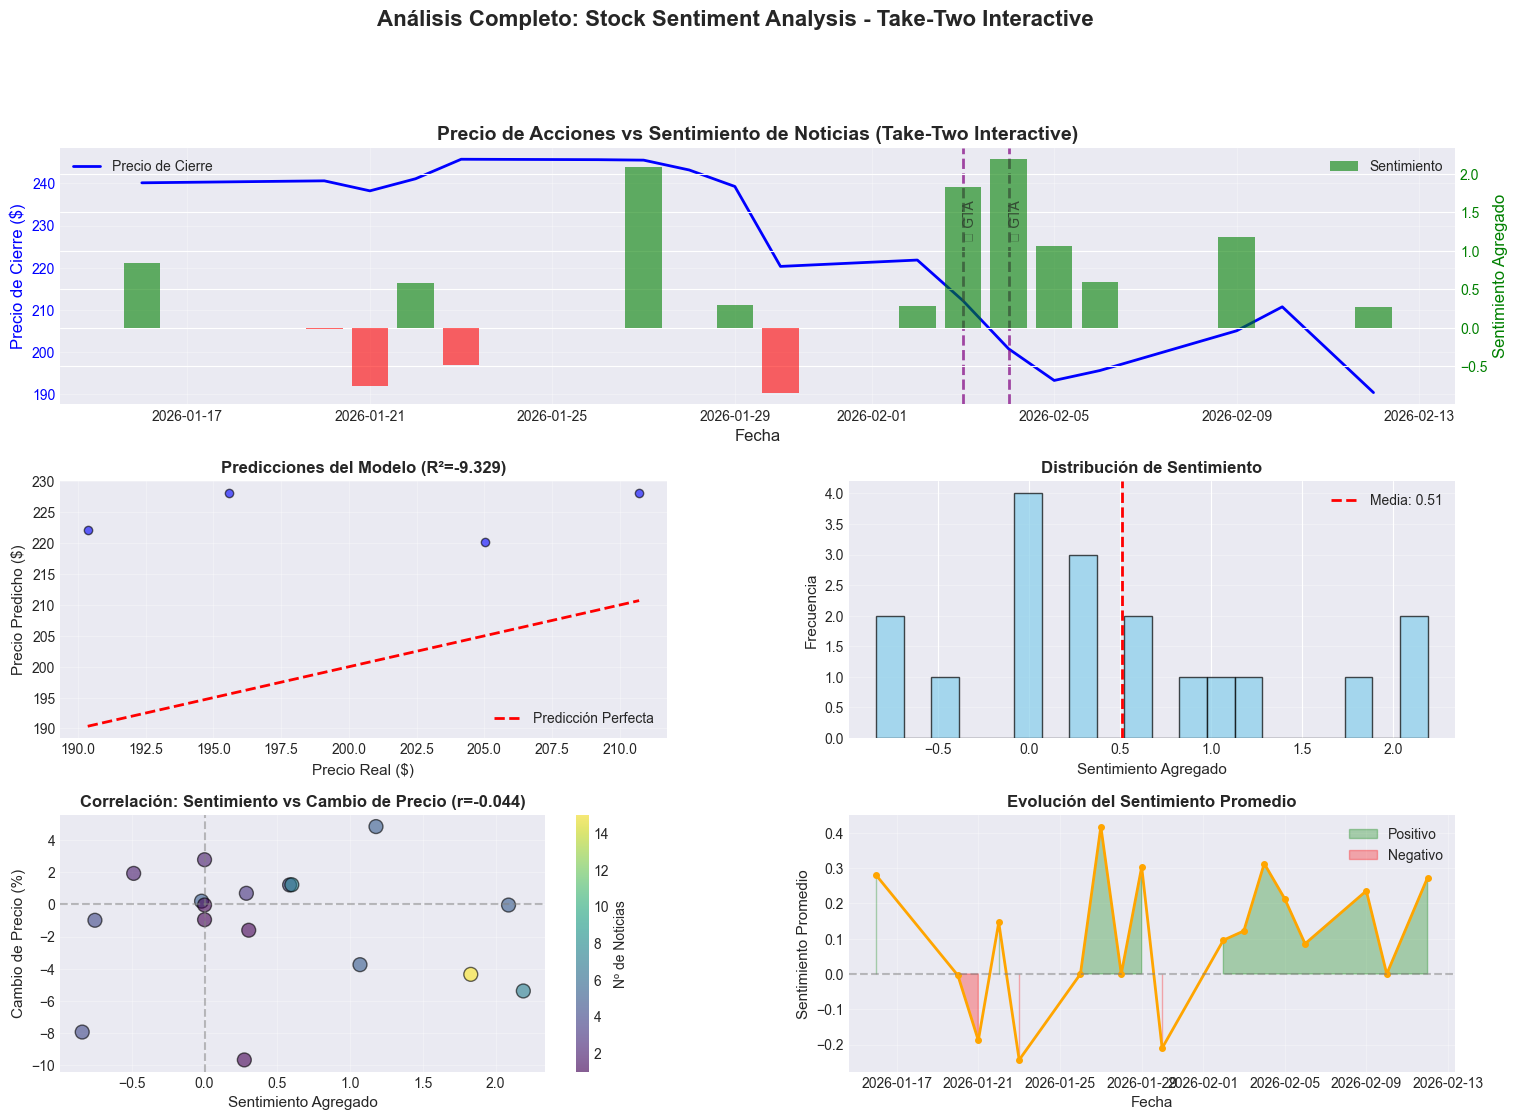

✅ Visualizaciones generadas exitosamente


In [11]:
# ============================================================================
# CELDA 10: VISUALIZACIÓN COMPLETA
# ============================================================================
# Crear un dashboard completo con 6 gráficos diferentes

print("📊 Generando visualizaciones...")

# Crear figura con subplots (3 filas, 2 columnas)
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# ============================================================================
# GRÁFICO 1: Precio vs Sentimiento (Principal)
# ============================================================================
ax1 = fig.add_subplot(gs[0, :])
ax1.set_xlabel('Fecha', fontsize=12)
ax1.set_ylabel('Precio de Cierre ($)', fontsize=12, color='blue')
line1 = ax1.plot(combined_data['Date'], combined_data['Close'], 
                 label='Precio de Cierre', color='blue', linewidth=2)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)

# Eje secundario para sentimiento (barras)
ax2 = ax1.twinx()
ax2.set_ylabel('Sentimiento Agregado', fontsize=12, color='green')
colors = ['green' if val >= 0 else 'red' for val in combined_data['sentiment_score']]
bars = ax2.bar(combined_data['Date'], combined_data['sentiment_score'], 
               label='Sentimiento', color=colors, alpha=0.6, width=0.8)
ax2.tick_params(axis='y', labelcolor='green')

# Marcar eventos de GTA con líneas verticales
if len(gta_days) > 0:
    for idx, row in gta_days.iterrows():
        ax1.axvline(x=row['Date'], color='purple', linestyle='--', alpha=0.7, linewidth=2)
        ax1.text(row['Date'], ax1.get_ylim()[1]*0.95, '🎮 GTA', 
                rotation=90, verticalalignment='top', fontsize=10, color='purple')

ax1.set_title('Precio de Acciones vs Sentimiento de Noticias (Take-Two Interactive)', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# ============================================================================
# GRÁFICO 2: Predicciones del Modelo
# ============================================================================
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(y_test, y_pred_test, alpha=0.6, color='blue', edgecolors='black')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Predicción Perfecta')
ax3.set_xlabel('Precio Real ($)', fontsize=11)
ax3.set_ylabel('Precio Predicho ($)', fontsize=11)
ax3.set_title(f'Predicciones del Modelo (R²={r2:.3f})', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# ============================================================================
# GRÁFICO 3: Distribución de Sentimiento
# ============================================================================
ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(combined_data['sentiment_score'], bins=20, color='skyblue', 
         edgecolor='black', alpha=0.7)
ax4.axvline(combined_data['sentiment_score'].mean(), color='red', 
            linestyle='--', linewidth=2, label=f'Media: {combined_data["sentiment_score"].mean():.2f}')
ax4.set_xlabel('Sentimiento Agregado', fontsize=11)
ax4.set_ylabel('Frecuencia', fontsize=11)
ax4.set_title('Distribución de Sentimiento', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# ============================================================================
# GRÁFICO 4: Correlación Sentimiento vs Cambio de Precio
# ============================================================================
ax5 = fig.add_subplot(gs[2, 0])
scatter = ax5.scatter(combined_data['sentiment_score'], combined_data['price_change'], 
                     c=combined_data['news_count'], cmap='viridis', 
                     alpha=0.6, edgecolors='black', s=100)
ax5.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax5.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax5.set_xlabel('Sentimiento Agregado', fontsize=11)
ax5.set_ylabel('Cambio de Precio (%)', fontsize=11)
ax5.set_title(f'Correlación: Sentimiento vs Cambio de Precio (r={corr_change:.3f})', 
              fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax5, label='Nº de Noticias')
ax5.grid(True, alpha=0.3)

# ============================================================================
# GRÁFICO 5: Evolución Temporal del Sentimiento
# ============================================================================
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(combined_data['Date'], combined_data['avg_sentiment'], 
         color='orange', linewidth=2, marker='o', markersize=4)
ax6.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax6.fill_between(combined_data['Date'], combined_data['avg_sentiment'], 0, 
                  where=(combined_data['avg_sentiment'] >= 0), 
                  color='green', alpha=0.3, label='Positivo')
ax6.fill_between(combined_data['Date'], combined_data['avg_sentiment'], 0, 
                  where=(combined_data['avg_sentiment'] < 0), 
                  color='red', alpha=0.3, label='Negativo')
ax6.set_xlabel('Fecha', fontsize=11)
ax6.set_ylabel('Sentimiento Promedio', fontsize=11)
ax6.set_title('Evolución del Sentimiento Promedio', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

# Título general
plt.suptitle('Análisis Completo: Stock Sentiment Analysis - Take-Two Interactive', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

print("✅ Visualizaciones generadas exitosamente")

In [12]:
# ============================================================================
# CELDA 11: RESUMEN Y CONCLUSIONES
# ============================================================================
# Generar un resumen completo del análisis realizado

print("\n" + "="*70)
print("📋 RESUMEN DEL ANÁLISIS")
print("="*70)

print(f"\n📊 Datos Analizados:")
print(f"   - Período: {combined_data['Date'].min()} a {combined_data['Date'].max()}")
print(f"   - Días analizados: {len(combined_data)}")
print(f"   - Total de noticias: {combined_data['news_count'].sum():.0f}")
print(f"   - Promedio de noticias/día: {combined_data['news_count'].mean():.1f}")

print(f"\n📈 Estadísticas de Precio:")
print(f"   - Precio inicial: ${combined_data['Close'].iloc[0]:.2f}")
print(f"   - Precio final: ${combined_data['Close'].iloc[-1]:.2f}")
print(f"   - Cambio total: {((combined_data['Close'].iloc[-1] / combined_data['Close'].iloc[0]) - 1) * 100:.2f}%")
print(f"   - Precio máximo: ${combined_data['Close'].max():.2f}")
print(f"   - Precio mínimo: ${combined_data['Close'].min():.2f}")

print(f"\n💭 Estadísticas de Sentimiento:")
print(f"   - Sentimiento promedio: {combined_data['avg_sentiment'].mean():.4f}")
print(f"   - Días con sentimiento positivo: {(combined_data['sentiment_score'] > 0).sum()}")
print(f"   - Días con sentimiento negativo: {(combined_data['sentiment_score'] < 0).sum()}")

print(f"\n🔗 Correlaciones:")
print(f"   - Sentimiento vs Precio: {corr_price:.4f}")
print(f"   - Sentimiento vs Cambio %: {corr_change:.4f}")
print(f"   - Sentimiento (lag 1) vs Cambio %: {corr_lag:.4f}")

print(f"\n🤖 Rendimiento del Modelo:")
print(f"   - R² Score: {r2:.4f}")
print(f"   - Error promedio: ${mae:.2f}")

print(f"\n🎮 Eventos GTA 6:")
print(f"   - Días con menciones: {len(gta_days)}")
if len(gta_days) > 0:
    print(f"   - Impacto en sentimiento: {(avg_sentiment_gta - avg_sentiment_normal):.4f}")

print("\n" + "="*70)
print("✅ ANÁLISIS COMPLETADO")
print("="*70)


📋 RESUMEN DEL ANÁLISIS

📊 Datos Analizados:
   - Período: 2026-01-16 a 2026-02-12
   - Días analizados: 18
   - Total de noticias: 75
   - Promedio de noticias/día: 4.2

📈 Estadísticas de Precio:
   - Precio inicial: $240.14
   - Precio final: $190.36
   - Cambio total: -20.73%
   - Precio máximo: $245.73
   - Precio mínimo: $190.36

💭 Estadísticas de Sentimiento:
   - Sentimiento promedio: 0.1022
   - Días con sentimiento positivo: 11
   - Días con sentimiento negativo: 4

🔗 Correlaciones:
   - Sentimiento vs Precio: -0.3168
   - Sentimiento vs Cambio %: -0.0445
   - Sentimiento (lag 1) vs Cambio %: -0.0889

🤖 Rendimiento del Modelo:
   - R² Score: -9.3285
   - Error promedio: $24.21

🎮 Eventos GTA 6:
   - Días con menciones: 2
   - Impacto en sentimiento: 0.1296

✅ ANÁLISIS COMPLETADO
